<a href="https://colab.research.google.com/github/priangshu17/AIRL-Coding-Assignment/blob/main/q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Install all dependencies (simpler!)
!pip install git+https://github.com/facebookresearch/segment-anything-2.git
!pip install transformers torch torchvision opencv-python matplotlib pillow scikit-image

  Cloning https://github.com/facebookresearch/segment-anything-2.git to /tmp/pip-req-build-rn1dgvgt
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything-2.git /tmp/pip-req-build-rn1dgvgt
  Resolved https://github.com/facebookresearch/segment-anything-2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.3 MB/s eta 0:00:00
  Created wheel for SAM-2: filename=sam_2-1.0-cp312-cp312-linux_x86_64.whl size=473730 sha256=c6d2f069750856d1db986f2451c3ab41b1c60bd8fb17943fd3055801a8fe8c69
  Stored in directory: /tmp/pip-ephem-wheel-cache-su8jncpp/wheels/b0/5b/a1/c16dafb8c3c0046f1158e7fa7570559a72085df5beab759ba0
  Created wheel 

In [2]:
#Download SAM 2 checkpoint
import os
!mkdir -p checkpoints
if not os.path.exists('checkpoints/sam2_hiera_large.pt'):
    !wget -P checkpoints https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt

--2025-10-04 08:39:02--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.51, 3.163.189.96, 3.163.189.14, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 897952466 (856M) [application/vnd.snesdev-page-table]
Saving to: ‘checkpoints/sam2_hiera_large.pt’

sam2_hiera_large.pt 100%[===================>] 856.35M   114MB/s    in 5.4s    

2025-10-04 08:39:08 (159 MB/s) - ‘checkpoints/sam2_hiera_large.pt’ saved [897952466/897952466]



In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from scipy import ndimage
from skimage import measure

In [10]:
class TextPromptedSAM2_CLIPSeg:
    """
    Text-prompted segmentation pipeline combining CLIPSeg + SAM 2
    Much easier to install than Grounding DINO!
    """

    def __init__(self,
                 sam2_checkpoint="checkpoints/sam2_hiera_large.pt",
                 sam2_config="sam2_hiera_l.yaml"):

        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {self.device}")

        # Initialize CLIPSeg
        print("Loading CLIPSeg...")
        self.clipseg_processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
        self.clipseg_model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
        self.clipseg_model.to(self.device)

        # Initialize SAM 2
        print("Loading SAM 2...")
        sam2_model = build_sam2(sam2_config, sam2_checkpoint, device=self.device)
        self.sam2_predictor = SAM2ImagePredictor(sam2_model)

        print("Pipeline initialized successfully!")

    def get_point_prompts_from_heatmap(self, heatmap, threshold=0.4, top_k=5):
        """
        Convert CLIPSeg heatmap to point prompts for SAM 2
        """
        # Threshold the heatmap
        binary_mask = heatmap > threshold

        if not binary_mask.any():
            return None, None

        # Find connected components
        labeled_mask = measure.label(binary_mask)
        regions = measure.regionprops(labeled_mask)

        if len(regions) == 0:
            return None, None

        # Get centroids of largest regions
        regions = sorted(regions, key=lambda x: x.area, reverse=True)[:top_k]

        point_coords = []
        point_labels = []

        for region in regions:
            y, x = region.centroid
            point_coords.append([x, y])
            point_labels.append(1)  # foreground point

        return np.array(point_coords), np.array(point_labels)

    def get_box_from_heatmap(self, heatmap, threshold=0.4):
        """
        Convert CLIPSeg heatmap to bounding box for SAM 2
        """
        binary_mask = heatmap > threshold

        if not binary_mask.any():
            return None

        # Find bounding box of the mask
        rows = np.any(binary_mask, axis=1)
        cols = np.any(binary_mask, axis=0)

        if not rows.any() or not cols.any():
            return None

        rmin, rmax = np.where(rows)[0][[0, -1]]
        cmin, cmax = np.where(cols)[0][[0, -1]]

        # Add some padding
        h, w = binary_mask.shape
        pad = 10
        rmin = max(0, rmin - pad)
        rmax = min(h, rmax + pad)
        cmin = max(0, cmin - pad)
        cmax = min(w, cmax + pad)

        return np.array([cmin, rmin, cmax, rmax])

    def segment(self, image_path, text_prompt, threshold=0.4, use_box=True):
        """
        Perform text-prompted segmentation

        Args:
            image_path: Path to input image
            text_prompt: Text description of object to segment
            threshold: CLIPSeg confidence threshold (0-1)
            use_box: If True, use box prompt; if False, use point prompts

        Returns:
            masks: Segmentation masks
            heatmap: CLIPSeg heatmap
            image: Original image
        """
        # Load image
        image = Image.open(image_path).convert("RGB")
        image_np = np.array(image)

        print(f"\nProcessing image: {image_np.shape}")
        print(f"Text prompt: '{text_prompt}'")

        # Step 1: Get heatmap from CLIPSeg
        print("\nStep 1: Running CLIPSeg...")
        inputs = self.clipseg_processor(
            text=[text_prompt],
            images=[image],
            return_tensors="pt",
            padding=True
        )
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.clipseg_model(**inputs)

        # Get heatmap and resize to original image size
        heatmap = outputs.logits[0].cpu().numpy()
        heatmap = cv2.resize(heatmap, (image_np.shape[1], image_np.shape[0]))

        # Normalize heatmap to 0-1
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

        print(f"✓ CLIPSeg heatmap generated (max: {heatmap.max():.3f}, min: {heatmap.min():.3f})")

        # Step 2: Convert heatmap to prompts
        self.sam2_predictor.set_image(image_np)

        if use_box:
            print("\nStep 2: Converting heatmap to box prompt...")
            box = self.get_box_from_heatmap(heatmap, threshold=threshold)

            if box is None:
                print("❌ No objects detected! Try lowering the threshold.")
                return None, heatmap, image_np

            print(f"✓ Box prompt: {box}")

            # Step 3: Run SAM 2
            print("\nStep 3: Running SAM 2 segmentation...")
            masks, scores, _ = self.sam2_predictor.predict(
                point_coords=None,
                point_labels=None,
                box=box[None, :],
                multimask_output=True
            )

            # Use the best mask
            best_idx = np.argmax(scores)
            final_mask = masks[best_idx:best_idx+1]
            print(f"✓ Generated mask with confidence={scores[best_idx]:.3f}")

        else:
            print("\nStep 2: Converting heatmap to point prompts...")
            point_coords, point_labels = self.get_point_prompts_from_heatmap(
                heatmap, threshold=threshold, top_k=5
            )

            if point_coords is None:
                print("❌ No objects detected! Try lowering the threshold.")
                return None, heatmap, image_np

            print(f"✓ Generated {len(point_coords)} point prompts")

            # Step 3: Run SAM 2
            print("\nStep 3: Running SAM 2 segmentation...")
            masks, scores, _ = self.sam2_predictor.predict(
                point_coords=point_coords,
                point_labels=point_labels,
                multimask_output=True
            )

            # Use the best mask
            best_idx = np.argmax(scores)
            final_mask = masks[best_idx:best_idx+1]
            print(f"✓ Generated mask with confidence={scores[best_idx]:.3f}")

        return final_mask, heatmap, image_np

    def visualize(self, image, masks, heatmap, text_prompt):
        """
        Visualize segmentation results
        """
        fig, axes = plt.subplots(1, 4, figsize=(24, 6))

        # Original image
        axes[0].imshow(image)
        axes[0].set_title("Original Image", fontsize=14, fontweight='bold')
        axes[0].axis('off')

        # CLIPSeg heatmap
        im = axes[1].imshow(heatmap, cmap='jet', alpha=0.7)
        axes[1].imshow(image, alpha=0.3)
        axes[1].set_title(f"CLIPSeg Heatmap\n'{text_prompt}'",
                         fontsize=14, fontweight='bold')
        axes[1].axis('off')
        plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

        # Thresholded heatmap
        axes[2].imshow(image)
        binary = heatmap > 0.4
        colored_mask = np.zeros((*binary.shape, 4))
        colored_mask[binary] = [1, 0, 0, 0.5]
        axes[2].imshow(colored_mask)
        axes[2].set_title("CLIPSeg Threshold\n(Seeds for SAM 2)",
                         fontsize=14, fontweight='bold')
        axes[2].axis('off')

        # SAM 2 segmentation
        axes[3].imshow(image)
        if masks is not None:
            for mask in masks:
                mask_bool = mask.astype(bool)  # Ensure boolean type
                colored_mask = np.zeros((*mask_bool.shape, 4))
                colored_mask[mask_bool] = [0, 1, 0, 0.6]
                axes[3].imshow(colored_mask)
        axes[3].set_title(f"SAM 2 Final Mask",
                         fontsize=14, fontweight='bold')
        axes[3].axis('off')

        plt.tight_layout()
        plt.show()

        return fig

In [11]:
# Initialize the pipeline
pipeline = TextPromptedSAM2_CLIPSeg()

Using device: cuda
Loading CLIPSeg...
Loading SAM 2...
Pipeline initialized successfully!


In [12]:
# Download a sample image
!wget -O sample_image.jpg https://images.unsplash.com/photo-1543466835-00a7907e9de1?w=800

image_path = "sample_image.jpg"

--2025-10-04 08:53:48--  https://images.unsplash.com/photo-1543466835-00a7907e9de1?w=800
Resolving images.unsplash.com (images.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to images.unsplash.com (images.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57083 (56K) [image/jpeg]
Saving to: ‘sample_image.jpg’

sample_image.jpg    100%[===================>]  55.75K  --.-KB/s    in 0.009s  

2025-10-04 08:53:48 (6.33 MB/s) - ‘sample_image.jpg’ saved [57083/57083]



In [13]:
# Run segmentation with text prompt
text_prompt = "dog"  # Change this to segment different objects

masks, heatmap, image = pipeline.segment(
    image_path=image_path,
    text_prompt=text_prompt,
    threshold=0.4,  # Lower (0.2-0.3) to detect more, higher (0.5-0.6) for precision
    use_box=True    # True for box prompt, False for point prompts
)


Processing image: (600, 800, 3)
Text prompt: 'dog'

Step 1: Running CLIPSeg...
✓ CLIPSeg heatmap generated (max: 1.000, min: 0.000)

Step 2: Converting heatmap to box prompt...
✓ Box prompt: [ 27  15 782 600]

Step 3: Running SAM 2 segmentation...
✓ Generated mask with confidence=0.930


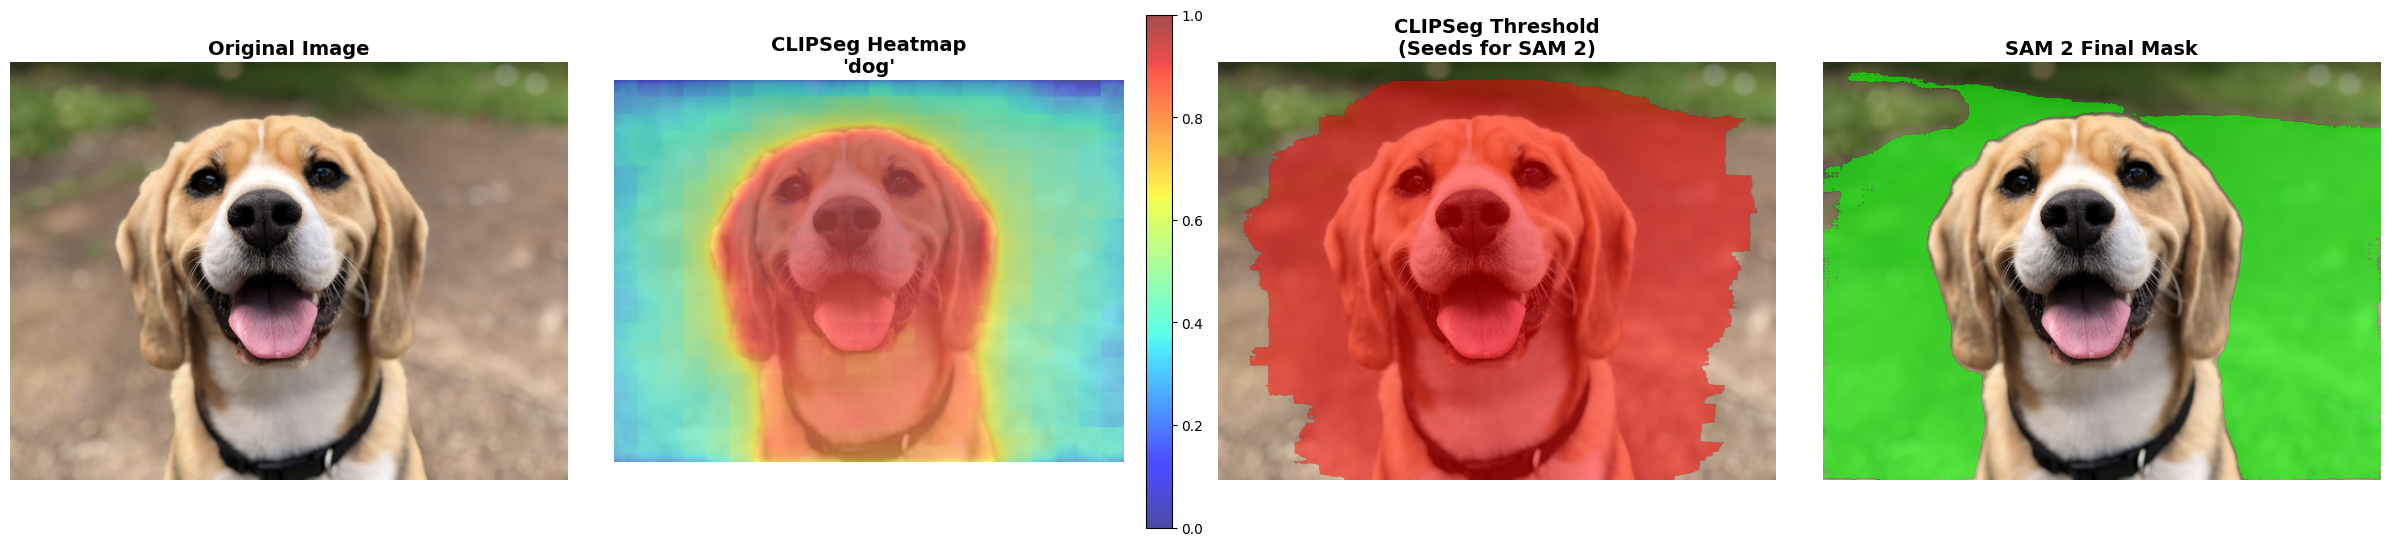


✅ Segmentation complete!


In [14]:
# Visualize results
if masks is not None:
    pipeline.visualize(image, masks, heatmap, text_prompt)
    print("\n✅ Segmentation complete!")
else:
    print("\n⚠️ No segmentation performed. Try lowering the threshold.")

In [20]:
!wget -O car_image.jpg https://images.unsplash.com/photo-1568605117036-5fe5e7bab0b7?q=80&w=1170&auto=format&fit=crop&ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D

car_image_path = "car_image.jpg"

--2025-10-04 09:05:23--  https://images.unsplash.com/photo-1568605117036-5fe5e7bab0b7?q=80
Resolving images.unsplash.com (images.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to images.unsplash.com (images.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3417219 (3.3M) [image/jpeg]
Saving to: ‘car_image.jpg’

car_image.jpg       100%[===================>]   3.26M  --.-KB/s    in 0.05s   

2025-10-04 09:05:23 (70.5 MB/s) - ‘car_image.jpg’ saved [3417219/3417219]



In [23]:
car_text_prompt = "car"  # Change this to segment different objects

masks, heatmap, image = pipeline.segment(
    image_path=car_image_path,
    text_prompt=car_text_prompt,
    threshold=0.4,  # Lower (0.2-0.3) to detect more, higher (0.5-0.6) for precision
    use_box=True    # True for box prompt, False for point prompts
)


Processing image: (3648, 5472, 3)
Text prompt: 'car'

Step 1: Running CLIPSeg...


/usr/local/lib/python3.12/dist-packages/transformers/image_processing_utils.py:51: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


✓ CLIPSeg heatmap generated (max: 1.000, min: 0.000)

Step 2: Converting heatmap to box prompt...
✓ Box prompt: [1241 1152 4184 2834]

Step 3: Running SAM 2 segmentation...
✓ Generated mask with confidence=0.790


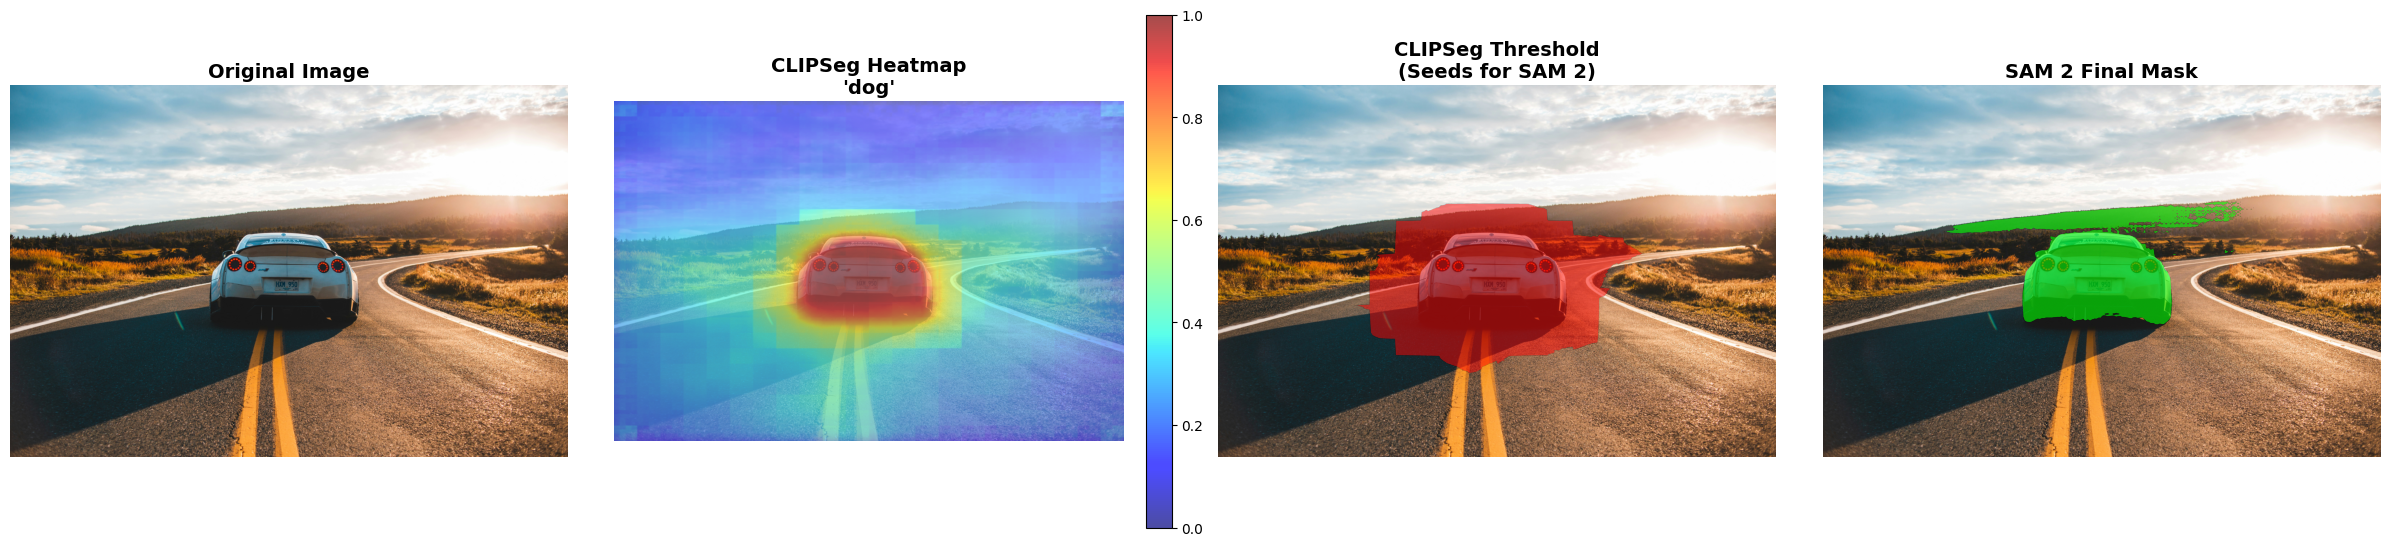


✅ Segmentation complete!


In [24]:
# Visualize results
if masks is not None:
    pipeline.visualize(image, masks, heatmap, text_prompt)
    print("\n✅ Segmentation complete!")
else:
    print("\n⚠️ No segmentation performed. Try lowering the threshold.")